In [47]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [48]:
assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
#smoke_test = 'CI' in os.environ

In [49]:
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')

In [50]:
from torch.distributions.utils import (_sum_rightmost, broadcast_all,
                                       lazy_property, tril_matrix_to_vec,
                                       vec_to_tril_matrix)

In [51]:
def make_pd_mat(size, tensor_of_vectors):
    x = vec_to_tril_matrix(tensor_of_vectors)
    for idx in range(size):
        x[:, idx, idx] = torch.exp(x[:, idx, idx])
    z_scale = torch.bmm(x, x.transpose(1, 2))
    return z_scale

In [52]:
import torch.nn.functional as F
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.input_dim = input_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim[0]*input_dim[1], hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        val = int((z_dim**2 + z_dim) / 2)
        self.fc22 = nn.Linear(hidden_dim, val) # z_dim**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.fc1(x.reshape(x.shape[0], self.input_dim[0] * self.input_dim[1]))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        A_vect = self.fc22(hidden)
        A = vec_to_tril_matrix(A_vect)
        z_scale = torch.bmm(A, A.transpose(1, 2))
        z_scale.add_(torch.eye(self.z_dim)*1e-4)
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)
        self.fc22 = nn.Linear(hidden_dim, input_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        mu = self.fc21(hidden)
        sigma = torch.exp(self.fc22(hidden))
        return mu, sigma


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=5, hidden_dim=250, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)
        # self.decoder = Decoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, sigma, x):
        # register PyTorch module `decoder` with Pyro
        # pyro.module("decoder", self.decoder)
        
        # setup hyperparameters for prior p(z)
        mu_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
        mu_scale = torch.eye(x[0].shape[1]).reshape(
            (1,x[0].shape[1],x[0].shape[1])).repeat(x.shape[0], 1, 1)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # sample from prior (value will be sampled by guide when computing the ELBO
            mu = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(mu_loc[i,:], mu_scale[i,:,:]))
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[i].shape[1])))
            
            with pyro.plate("data_loop_{}".format(i), x[i].shape[0]):
                pyro.sample("obs_{}".format(i), dist.MultivariateNormal(mu, scale),
                                obs=x[i, :, :])          
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, sigma, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x[i].unsqueeze(0))

            # sample the latent code z
            z = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(z_loc, z_scale))
            
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[0].shape[1])))#.repeat(x.shape[i], 1, 1))

In [53]:
# write a function to find this exact posterior 
def get_posterior_cov_mv_gaussian(n, sigma, sigma_0):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, 1/n * sigma)
    return(p2)

def get_posterior_mean_mv_gaussian(n, sigma, sigma_0, mu_0, data):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    
    middle_part = data.mean(axis=0)
    
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, middle_part)
    
    p3 = np.matmul(1/n * sigma, sum_part)
    p4 = np.matmul(p3, mu_0)
    return(p2 + p4)

In [12]:
def multivar_random(size, normal_params, gamma_params, num_samples):   

    # simulate two random covariance matrices (PSD) for sigma and sigma_0
    mat = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))
    
    mat_0 = np.random.gamma(gamma_params[2], gamma_params[3], size=size**2).reshape((size, size))
    sigma_mat_0 = torch.tensor(np.dot(mat_0, mat_0.transpose()))
    
    # simulate some random means
    mu_vector = torch.tensor(np.random.multivariate_normal(normal_params, sigma_mat_0, size=1))[0]

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, sigma_mat, size=num_samples).astype("float32"))
    
    return(data, mu_vector, sigma_mat, sigma_mat_0)

In [29]:
X = []
means = []
sigma_mats = []
sigma_0s = []
for idx in range(10000):
    random_means = np.random.sample(size=5) 
    
    data, mu_vector, sigma_mat, sigma_mat_0 = multivar_random(5, [1]*5, [0.5,.5,.5,.5], num_samples=500)
    X.append(data)
    means.append(mu_vector)
    sigma_mats.append(sigma_mat)
    sigma_0s.append(sigma_mat_0)

In [30]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = (500, 5)
mu = stats.norm.rvs(size=input_dim)

# setup the VAE
vae = VAE(use_cuda=False, input_dim=input_dim, z_dim=5)

adam_args = {"lr": 0.00001}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_loader = DataLoader(X, batch_size=5000, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

train_elbo = []

for epoch in range(50):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    print("Epoch: ", epoch, end = "\r")
    for x in train_loader:
        # x = x.cuda()
        epoch_loss += svi.step(torch.eye(input_dim[1]), x)

    # report training diagnostics
    if not epoch % 2:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 6925.8566
[epoch 002]  average training loss: 5943.5710
[epoch 004]  average training loss: 5280.6412
[epoch 006]  average training loss: 4904.5067
[epoch 008]  average training loss: 4692.3833
[epoch 010]  average training loss: 4598.4233
[epoch 012]  average training loss: 4486.1435
[epoch 014]  average training loss: 4434.5465
[epoch 016]  average training loss: 4363.7432
[epoch 018]  average training loss: 4290.0309
[epoch 020]  average training loss: 4222.8461
[epoch 022]  average training loss: 4185.5833
[epoch 024]  average training loss: 4140.3276
[epoch 026]  average training loss: 4102.7654
[epoch 028]  average training loss: 4057.4675
[epoch 030]  average training loss: 4056.9253
[epoch 032]  average training loss: 4034.0373
[epoch 034]  average training loss: 4021.6789
[epoch 036]  average training loss: 4009.8002
[epoch 038]  average training loss: 3994.0164
[epoch 040]  average training loss: 3988.5110
[epoch 042]  average training loss

Text(0, 0.5, 'ELBO loss')

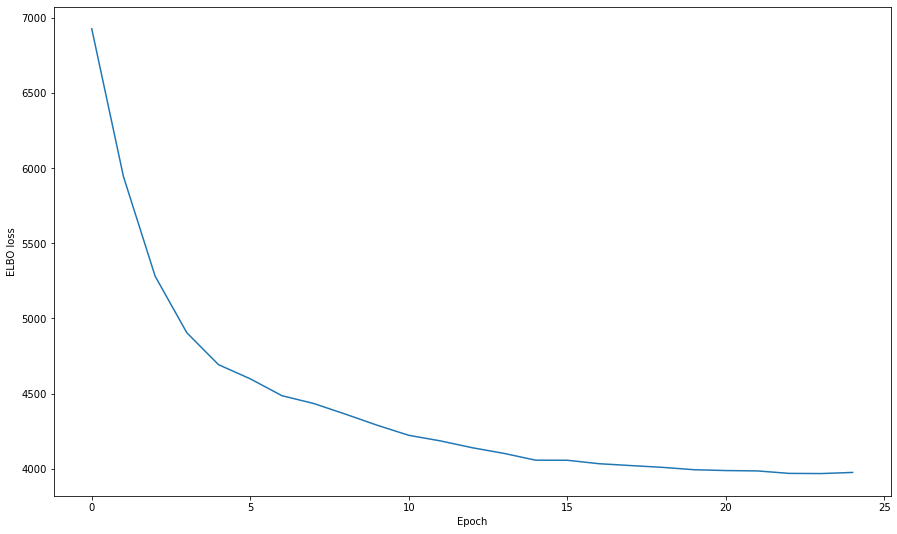

In [31]:
plt.figure(figsize=(15, 9))
plt.plot([i for i in range(len(train_elbo))], train_elbo)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")

In [32]:
count = 0
for name, value in pyro.get_param_store().items():
    print(name)

encoder$$$fc1.weight
encoder$$$fc1.bias
encoder$$$fc21.weight
encoder$$$fc21.bias
encoder$$$fc22.weight
encoder$$$fc22.bias
scale_0
scale_1
scale_2
scale_3
scale_4
scale_5
scale_6
scale_7
scale_8
scale_9
scale_10
scale_11
scale_12
scale_13
scale_14
scale_15
scale_16
scale_17
scale_18
scale_19
scale_20
scale_21
scale_22
scale_23
scale_24
scale_25
scale_26
scale_27
scale_28
scale_29
scale_30
scale_31
scale_32
scale_33
scale_34
scale_35
scale_36
scale_37
scale_38
scale_39
scale_40
scale_41
scale_42
scale_43
scale_44
scale_45
scale_46
scale_47
scale_48
scale_49
scale_50
scale_51
scale_52
scale_53
scale_54
scale_55
scale_56
scale_57
scale_58
scale_59
scale_60
scale_61
scale_62
scale_63
scale_64
scale_65
scale_66
scale_67
scale_68
scale_69
scale_70
scale_71
scale_72
scale_73
scale_74
scale_75
scale_76
scale_77
scale_78
scale_79
scale_80
scale_81
scale_82
scale_83
scale_84
scale_85
scale_86
scale_87
scale_88
scale_89
scale_90
scale_91
scale_92
scale_93
scale_94
scale_95
scale_96
scale_97
scal

scale_2287
scale_2288
scale_2289
scale_2290
scale_2291
scale_2292
scale_2293
scale_2294
scale_2295
scale_2296
scale_2297
scale_2298
scale_2299
scale_2300
scale_2301
scale_2302
scale_2303
scale_2304
scale_2305
scale_2306
scale_2307
scale_2308
scale_2309
scale_2310
scale_2311
scale_2312
scale_2313
scale_2314
scale_2315
scale_2316
scale_2317
scale_2318
scale_2319
scale_2320
scale_2321
scale_2322
scale_2323
scale_2324
scale_2325
scale_2326
scale_2327
scale_2328
scale_2329
scale_2330
scale_2331
scale_2332
scale_2333
scale_2334
scale_2335
scale_2336
scale_2337
scale_2338
scale_2339
scale_2340
scale_2341
scale_2342
scale_2343
scale_2344
scale_2345
scale_2346
scale_2347
scale_2348
scale_2349
scale_2350
scale_2351
scale_2352
scale_2353
scale_2354
scale_2355
scale_2356
scale_2357
scale_2358
scale_2359
scale_2360
scale_2361
scale_2362
scale_2363
scale_2364
scale_2365
scale_2366
scale_2367
scale_2368
scale_2369
scale_2370
scale_2371
scale_2372
scale_2373
scale_2374
scale_2375
scale_2376
scale_2377

scale_4786
scale_4787
scale_4788
scale_4789
scale_4790
scale_4791
scale_4792
scale_4793
scale_4794
scale_4795
scale_4796
scale_4797
scale_4798
scale_4799
scale_4800
scale_4801
scale_4802
scale_4803
scale_4804
scale_4805
scale_4806
scale_4807
scale_4808
scale_4809
scale_4810
scale_4811
scale_4812
scale_4813
scale_4814
scale_4815
scale_4816
scale_4817
scale_4818
scale_4819
scale_4820
scale_4821
scale_4822
scale_4823
scale_4824
scale_4825
scale_4826
scale_4827
scale_4828
scale_4829
scale_4830
scale_4831
scale_4832
scale_4833
scale_4834
scale_4835
scale_4836
scale_4837
scale_4838
scale_4839
scale_4840
scale_4841
scale_4842
scale_4843
scale_4844
scale_4845
scale_4846
scale_4847
scale_4848
scale_4849
scale_4850
scale_4851
scale_4852
scale_4853
scale_4854
scale_4855
scale_4856
scale_4857
scale_4858
scale_4859
scale_4860
scale_4861
scale_4862
scale_4863
scale_4864
scale_4865
scale_4866
scale_4867
scale_4868
scale_4869
scale_4870
scale_4871
scale_4872
scale_4873
scale_4874
scale_4875
scale_4876

In [54]:
vae.encoder.eval()

Encoder(
  (fc1): Linear(in_features=2500, out_features=250, bias=True)
  (fc21): Linear(in_features=250, out_features=5, bias=True)
  (fc22): Linear(in_features=250, out_features=15, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [58]:
idx = 0
X[idx].shape
mean_pred = vae.encoder.forward(X[idx].unsqueeze(0))[0]
mean_act = means[idx]
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[1.0284, 0.6531, 1.4000, 1.3867, 0.3650]], grad_fn=<AddmmBackward0>).
Actual means: tensor([1.2603, 0.6317, 0.9386, 1.2214, 0.1818], dtype=torch.float64).


In [60]:
x_i, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [.5]*4, 500)
mean_pred = vae.encoder.forward(x_i.reshape(1, 500, 5))[0]
mean_act = get_posterior_mean_mv_gaussian(50, sigma, sigma_0, mu_vector, x_i)
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[1.4306, 0.4794, 0.5933, 0.4640, 0.3707]], grad_fn=<AddmmBackward0>).
Actual means: tensor([1.2662, 0.7592, 0.8245, 0.2974, 0.4058], dtype=torch.float64).
